In [3]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
from mpas_tools.planar_hex import make_planar_hex_mesh
from mpas_tools.mesh.conversion import convert, cull, mask
from mpas_tools.io import write_netcdf
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from geometric_features import read_feature_collection
from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import json
import mosaic

## In this NB, I copy BMM's work... (but like in a messier, less efficient way)
Parts of this are copied from functions in the [basic_surface_wmt.py script for his wmt package](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/8c78368d03a31d78923361ae6814c407fef3b045/ocean/AMOC/watermassanalysis/examples/basic_surface_wmt/basic_surface_wmt.py)

In [4]:
print(mpas_tools.__version__)

1.2.2


In [5]:
# # create a geojson file (geojson.io)
# LS_test_gjson = {
#   "type": "FeatureCollection",
#   "features": [
#     {
#       "type": "Feature",
#       "properties": {
#         "name":"Labrador Sea... sort of",
#         "tags":"Labrador_Sea;Davis_Strait",
#         "object":"region",
#         "component":"ocean",
#         "author":"Kaila Uyeda"},
#       "geometry": {
#         "coordinates": [
#           [
#             [
#               -66.78654628714224,
#               67.04329908963595
#             ],
#             [
#               -64.10071681349476,
#               57.52316136748382
#             ],
#             [
#               -56.444059335337954,
#               52.23600877585457
#             ],
#             [
#               -44.02529898728204,
#               60.55350636692381
#             ],
#             [
#               -49.99073597744223,
#               67.80090427662248
#             ],
#             [
#               -66.78654628714224,
#               67.04329908963595
#             ]
#           ]
#         ],
#         "type": "Polygon"
#       }
#     }
#   ]
# }

# wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
# # save to a geojson file
# # with = open and then close
# # w = write mode

# with open(wmtnb_filepath+'LS_test.geojson','w') as f:
#     json.dump(LS_test_gjson, f, indent=2)

# print('file saved')

In [6]:
# bichan_filepath = '/pscratch/sd/k/kuyeda/bichan/mpaso/2km/'
# init = xr.open_dataset(bichan_filepath + '2km_channel_init.nc')
# cull = xr.open_dataset(bichan_filepath + '2km_channel_cull.nc')
# forcing = xr.open_dataset(bichan_filepath + '2km_channel_forcing.nc')
# base = xr.open_dataset(bichan_filepath + '2km_channel_base.nc')
# base

In [7]:
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
dsMesh = mesh
dsMesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB ...
    lonCell                        (nCells) float64 2MB ...
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1163)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_zstar_weight:                                       1.0
    config_rx1_horiz_smooth_open_ocean_cells:                      20
    config_rx1_min_levels:                                         3
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...

In [14]:
# convert geojson to .nc mask file

wmtnb_filepath = './'
fcMask = read_feature_collection(wmtnb_filepath + 'LS_test.geojson')
# pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell','edge','vertex'), pool=pool
)

In [15]:
dsMasks

<xarray.Dataset> Size: 6MB
Dimensions:            (nCells: 236853, nRegions: 1, nEdges: 719506,
                        nVertices: 482371)
Dimensions without coordinates: nCells, nRegions, nEdges, nVertices
Data variables:
    regionCellMasks    (nCells, nRegions) int32 947kB 0 0 0 0 0 0 ... 0 0 0 0 0
    regionNames        (nRegions) |S64 64B b'Labrador Sea... sort of'
    regionEdgeMasks    (nEdges, nRegions) int32 3MB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    regionVertexMasks  (nVertices, nRegions) int32 2MB 0 0 0 0 0 0 ... 0 0 0 0 0

In [16]:
np.unique(dsMasks.regionVertexMasks.isel(nRegions=0))

array([0, 1], dtype=int32)

In [46]:
dsMasks = xr.open_dataset('./LS_test_masks.nc')
cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)

In [47]:
cells_inside = np.int32(dsMesh.nCells.where(cellmask,drop=True))
vertices_around_cells = dsMesh.verticesOnCell.isel(nCells=cells_inside.astype(np.int32))
vertices_ids = np.int32(np.unique(vertices_around_cells.where(vertices_around_cells!=0))[:-1]) -1

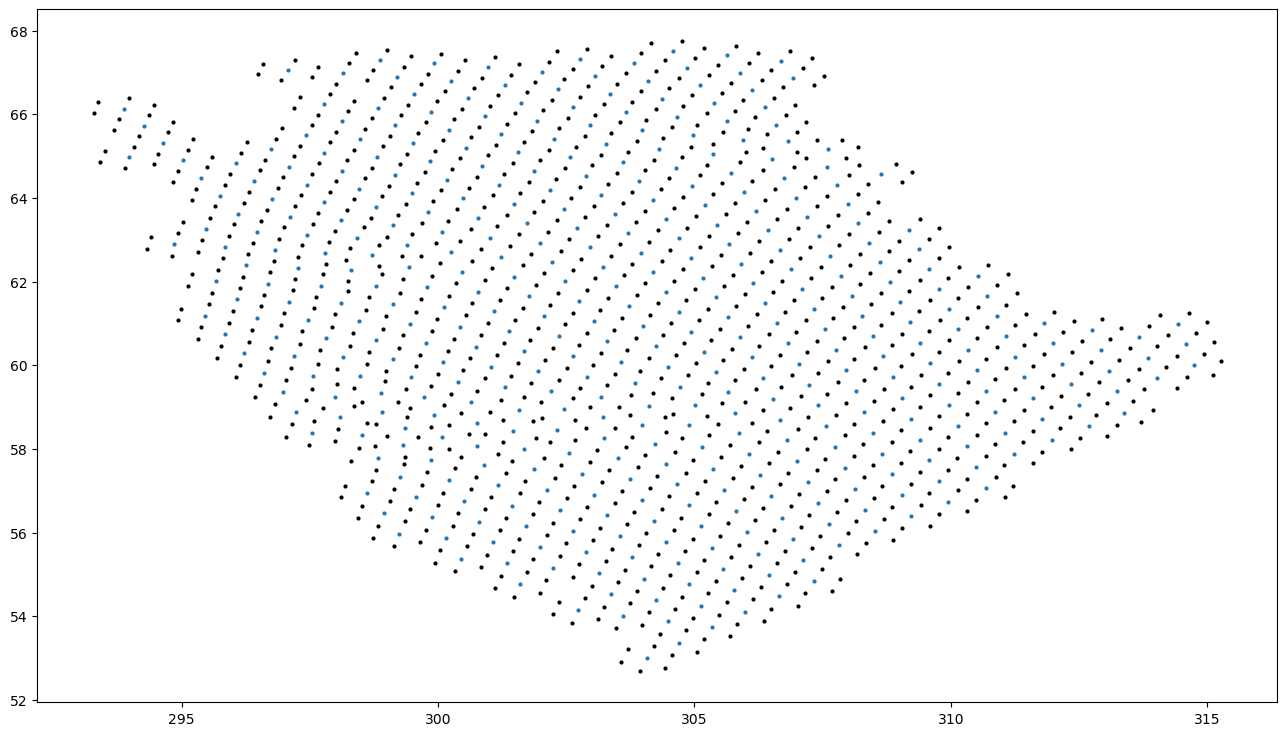

In [48]:
plt.figure(figsize=(16, 9))
plt.plot(
    dsMesh.lonCell[cells_inside]*360/(2*np.pi),
    dsMesh.latCell[cells_inside]*360/(2*np.pi),
    "o",
    markersize=2
)
plt.plot(
    dsMesh.lonVertex[vertices_ids]*360/(2*np.pi),
    dsMesh.latVertex[vertices_ids]*360/(2*np.pi),
    ".",
    markersize=4,
    color="black"
)

In [49]:
# convert geojson to .nc mask file

wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
fcMask = read_feature_collection(wmtnb_filepath + 'LS_test.geojson')
# pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell', 'vertex', 'edge'), pool=pool
)
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_CEV_masks.nc', format='NETCDF4', mode='w')

NameError: name 'pool' is not defined

In [ ]:
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_CEV_masks.nc', format='NETCDF4', mode='w')

In [50]:
mask = xr.open_dataset(wmtnb_filepath + 'LS_CEV_masks.nc')
mask = dsMasks

### scatter plots of data variables from the mesh dataset

In [51]:
dvs_to_plot = ['fCell','temperature','salinity','temperatureSurfaceValue','salinitySurfaceValue','surfaceVelocityZonal','surfaceVelocityMeridional',
              'SSHGradientZonal','SSHGradientMeridional','normalVelocity']
# only normal velocity is found at the edges. all other variables are at cell centers

# select the time step and the surface vertical level (there is only one time step...)
dsMesh_t0s0 = dsMesh[dvs_to_plot].isel(Time=-1,nVertLevels=0)

In [53]:
ds

<xarray.DataArray 'normalVelocity' (nEdges: 719506)> Size: 6MB
array([ 0.224603, -0.051992,  0.312011, ..., -0.119253,  0.033361,  0.179512],
      shape=(719506,))
Dimensions without coordinates: nEdges
Attributes:
    units:      m s^{-1}
    long_name:  horizontal velocity, normal component to an edge

Text(0.5, 1.0, 'normalVelocity t=0, z=0')

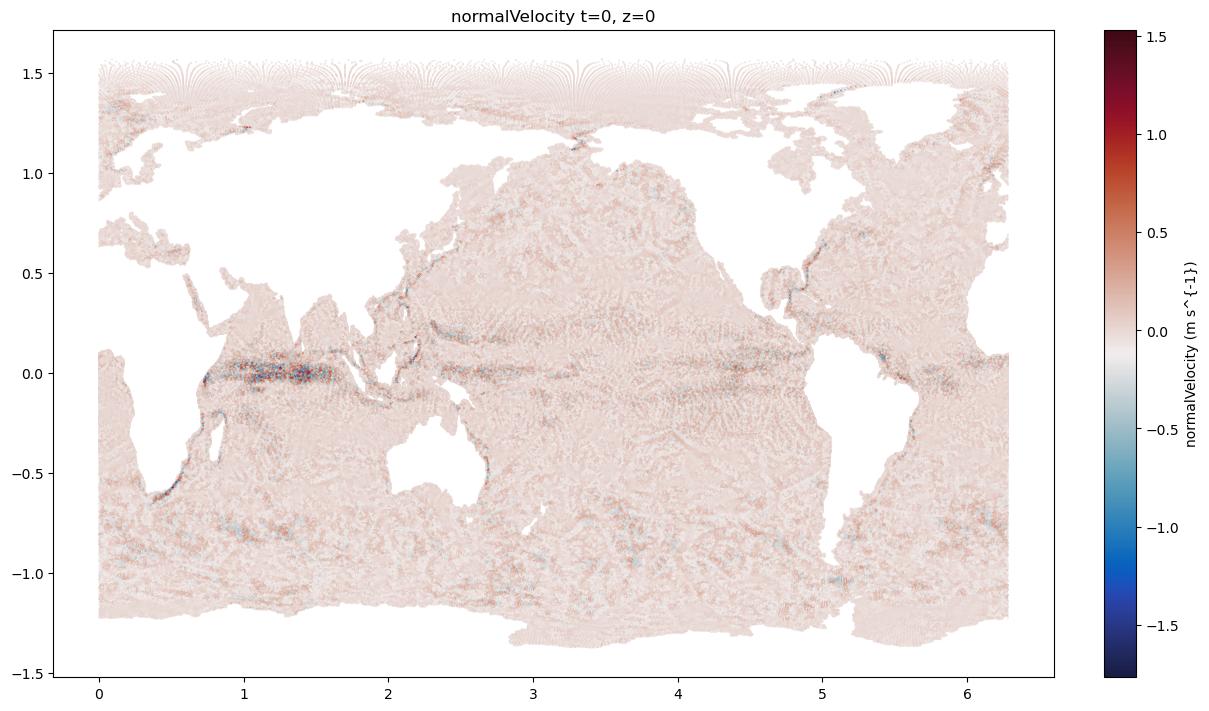

In [52]:
# plot normal velos (not included in the for loop because it relies on lonEdge, latEdge instead of cell centers :/
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,7))
ds = dsMesh_t0s0[dvs_to_plot[-1]]
im = ax.scatter(dsMesh.lonEdge, dsMesh.latEdge, c=ds, s=0.1, vmin=ds.min(),vmax=ds.max(), cmap=cmo.balance)
fig.colorbar(im, ax =ax, label= dvs_to_plot[-1] + ' (' + ds.units + ')')
ax.set_title(dvs_to_plot[-1] + ' t=0, z=0')

# save figs 
# fig_path = '/global/homes/k/kuyeda/WMT_NBs/initial_figs/'
# plt.savefig(fig_path + dvs_to_plot[-1] + '.png' , bbox_inches='tight')
# plt.close(fig)

In [39]:
# fig_path = '/global/homes/k/kuyeda/WMT_NBs/initial_figs/'

# for i in range(0,len(dvs_to_plot)-1): # all dvs excluding normal velocity
#     fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,7))
#     ds = dsMesh_t0s0[dvs_to_plot[i]]
#     im = ax.scatter(dsMesh.lonCell, dsMesh.latCell, c=ds, s=0.1, vmin=ds.min(),vmax=ds.max(), cmap=cmo.balance)
#     fig.colorbar(im, ax =ax, label= dvs_to_plot[i] + ' (' + ds.units + ')')
#     ax.set_title(dvs_to_plot[i] + ' t=0, z=0')
#     # plt.savefig(fig_path + dvs_to_plot[i] + '.png' , bbox_inches='tight')
#     # plt.close(fig)
    

### plot of mask from mesh data, masked with mask data

(51.5, 68.0)

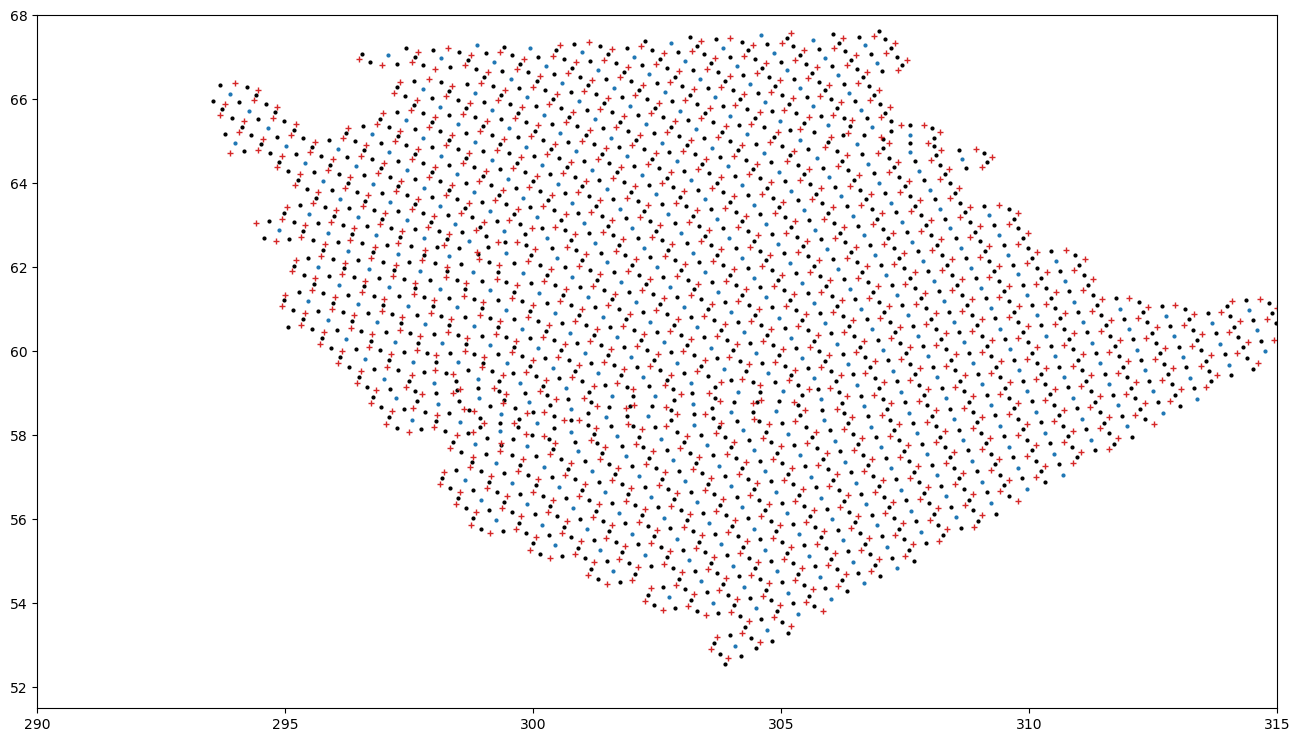

In [16]:

cellmasks = mask.regionCellMasks.isel(nRegions=0).astype(bool)
vertexmasks = mask.regionVertexMasks.isel(nRegions=0).astype(bool)
edgemasks = mask.regionEdgeMasks.isel(nRegions=0).astype(bool)

plt.figure(figsize=(16, 9))
plt.plot(
    mesh.lonCell[cellmasks]*360/(2*np.pi),
    mesh.latCell[cellmasks]*360/(2*np.pi),
    "o",
    markersize=2
)
plt.plot(
    mesh.lonEdge[edgemasks]*360/(2*np.pi),
    mesh.latEdge[edgemasks]*360/(2*np.pi),
    ".",
    markersize=4,
    color="black"
)
# plt.plot(
#     mesh.lonVertex*360/(2*np.pi),
#     mesh.latVertex*360/(2*np.pi),
#     "+",
#     markersize=2,
#     color="C3"
# )
plt.plot(
    mesh.lonVertex[vertexmasks]*360/(2*np.pi),
    mesh.latVertex[vertexmasks]*360/(2*np.pi),
    "+",
    markersize=4,
    color="C3"
)
plt.xlim(290, 315)
plt.ylim(51.5, 68)

### plots of data variables from simulations

In [2]:
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
ds = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-09-01.nc')

# prefix = 'timeMonthly_avg_'

# # get the active tracers
# active_tracers_keys = [i for i in ds.data_vars.keys() if i.startswith(prefix + 'active')]
# active_tracers = ds[active_tracers_keys]
# # active_tracers

# # get the fluxes
# # remove OceanRegion and maxGlobalStats and minGlobalStats
# excluded_strings = ['avgValueWithinOceanLayerRegion','avgValueWithinOceanRegion','GlobalStats']

# fluxes_keys = [
#     i for i in ds.data_vars.keys() 
#     if ('Flux' in i) and all(substring not in i for substring in excluded_strings)
# ]

# fluxes = ds[fluxes_keys]
# # fluxes

# # get velocities
# included_strings = ['Velocity','velocity']

# velos_keys = [
#     i for i in ds.data_vars.keys() 
#     if any(substring in i for substring in included_strings) and all(substring not in i for substring in excluded_strings)
# ]

# velos = ds[velos_keys]
# # velos

dvs_to_plot = ['timeMonthly_avg_activeTracers_temperature','timeMonthly_avg_activeTracers_salinity','timeMonthly_avg_latentHeatFlux',
               'timeMonthly_avg_sensibleHeatFlux','timeMonthly_avg_velocityMeridional','timeMonthly_avg_velocityZonal','timeMonthly_avg_normalVelocity',
               'timeMonthly_avg_vertVelocityTop']

/tmp/ipykernel_1490237/1006087627.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-09-01.nc')


In [3]:
nVertLevels_ind = 30
nVertLevelsP1_ind = 30
dsSims = ds[dvs_to_plot].isel(Time=0,nVertLevels=nVertLevels_ind)
# dsSims

### plot normal velocity and vertical velocity (defined at top of cell) 
>- coordinates are ```nEdges``` for the ```normalVelocity```
>- coordinates are ```nVertLevelsP1``` for the ```vertVelocityTop```

NameError: name 'dsMesh' is not defined

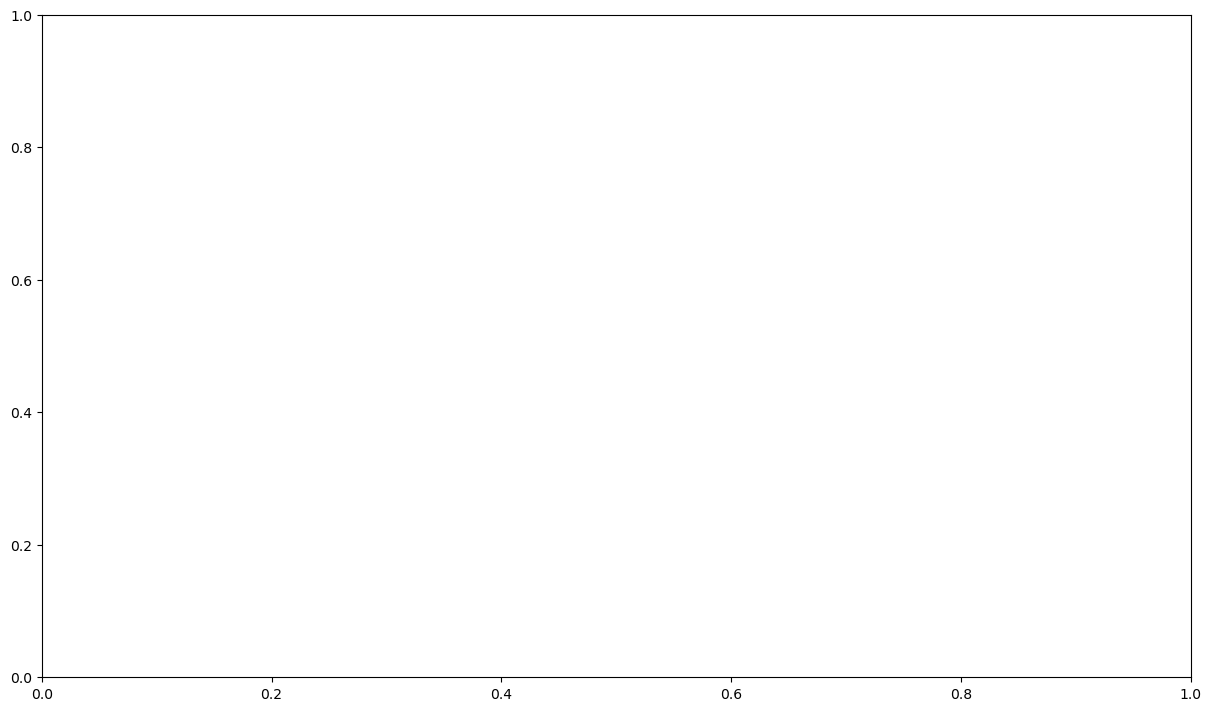

In [4]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True, figsize=(12,7))
dsnV = ds['timeMonthly_avg_normalVelocity'].isel(Time=0, nVertLevels= nVertLevels_ind)
im = ax.scatter(dsMesh.lonEdge, dsMesh.latEdge, c = dsnV, s=0.1, vmin = dsnV.min(), vmax = dsnV.max(), cmap = cmo.balance)
fig.colorbar(im, ax = ax, label = 'normalVelocity' + ' (' + dsnV.units + ')')
ax.set_title('timeMonthly_avg_normalVelocity t=0, z=30')

# save figs 
# fig_path = '/global/homes/k/kuyeda/WMT_NBs/initial_figs/'
# plt.savefig(fig_path + 'normalVelocity.png' , bbox_inches='tight')
# plt.close(fig)

In [296]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True, figsize=(12,7))
dsvVT = ds['timeMonthly_avg_vertVelocityTop'].isel(Time=0, nVertLevelsP1= nVertLevels_ind)
im = ax.scatter(dsMesh.lonCell, dsMesh.latCell, c = dsvVT, s=0.1, vmin = dsvVT.min(), vmax = dsvVT.max(), cmap = cmo.balance)
fig.colorbar(im, ax = ax, label = 'vertVelocityTop' + ' (' + dsvVT.units + ')')
ax.set_title('timeMonthly_avg_vertVelocityTop t=0, z=30')

# save figs 
# fig_path = '/global/homes/k/kuyeda/WMT_NBs/initial_figs/'
# plt.savefig(fig_path + 'vertVelocityTop.png' , bbox_inches='tight')
# plt.close(fig)

In [308]:
fig_path = '/global/homes/k/kuyeda/WMT_NBs/initial_figs/'

for i in range(0,len(dvs_to_plot)-2): # all dvs excluding normal velocity and vertVelocityTop
    fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,7))
    ds_var = dsSims[dvs_to_plot[i]]
    im = ax.scatter(dsMesh.lonCell, dsMesh.latCell, c=ds_var, s=0.1, vmin=ds_var.min(),vmax=ds_var.max(), cmap=cmo.balance)
    fig.colorbar(im, ax =ax, label= dvs_to_plot[i] + ' (' + ds_var.units + ')')
    ax.set_title(dvs_to_plot[i] + ' t=0, z=' + str(nVertLevels_ind))
    plt.savefig(fig_path + dvs_to_plot[i] + '.png' , bbox_inches='tight')
    plt.close(fig)
    

At this point, we have a mesh file (dsMesh) with latcell, loncell, actual coordinates, ig, and we also have a mask (mask) to specify *where* we want to study (region).\
So we want to label the mesh file with the region of study... \
mask.regionCellMasks (nCells, nRegions) $\rightarrow$ dsMesh has nCells as a dimension... so we'd want to align them over where their ncells values are the same...

In [84]:
mesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB 1.57 -0.4633 ... 0.1429
    lonCell                        (nCells) float64 2MB 5.919 0.6299 ... 2.347
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1163)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_zstar_weight:                                       1.0
    config_rx1_horiz_smooth_open_ocean_cells:                      20
    config_rx1_min_levels:                                         3
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...

In [86]:
# give mask regionCellMasks datavariable a regionNames coordinate
coord = mask.regionCellMasks
coord.coords['regionNames'] = mask.regionNames.astype(str)

# instead of nRegions as dimension, make regionNames dimension (string vs 0 or 1)
coord.swap_dims({'nRegions':'regionNames'})
coord_mask = coord

In [88]:
booled = coord_mask.astype(bool)

now restructure the coordinates for lats and lons to be in degrees

In [89]:
coord_latCell = np.rad2deg(mesh.latCell)
coord_lonCell = np.rad2deg(mesh.lonCell)
coord_areaCell = mesh.areaCell

In [90]:
# combine all the coordinates
coords = xr.merge([coord_mask, coord_latCell, coord_lonCell, coord_areaCell])
coords

<xarray.Dataset> Size: 7MB
Dimensions:          (nRegions: 1, nCells: 236853)
Coordinates:
    regionNames      (nRegions) <U64 256B 'Labrador Sea... sort of'
Dimensions without coordinates: nRegions, nCells
Data variables:
    regionCellMasks  (nCells, nRegions) int32 947kB ...
    latCell          (nCells) float64 2MB 89.94 -26.55 -26.55 ... 25.55 8.189
    lonCell          (nCells) float64 2MB 339.1 36.09 108.0 ... 238.5 134.5
    areaCell         (nCells) float64 2MB ...

Here, he "builds and applies a subdomain". I don't know what that means. 

In [91]:
# make the nCell dimension a coordinate
coords['nCells'] = coords.nCells
coords

# select a subdomain that is a box. It is bounded above and below by -100N and 40N and east and west by 0E and 85E.
subdomain = [
    coords.lonCell > -100,
    coords.lonCell < 40,
    coords.latCell > 0,
    coords.latCell < 85,]

subdomain = np.logical_and.reduce(subdomain)
coords = coords.isel(nCells=subdomain)

coords['regionCellMasks'] = coords.regionCellMasks.astype(bool)
coords

<xarray.Dataset> Size: 118kB
Dimensions:          (nRegions: 1, nCells: 3573)
Coordinates:
    regionNames      (nRegions) <U64 256B 'Labrador Sea... sort of'
  * nCells           (nCells) int64 29kB 36 5960 5961 ... 236609 236620 236802
Dimensions without coordinates: nRegions
Data variables:
    regionCellMasks  (nCells, nRegions) bool 4kB False False ... False False
    latCell          (nCells) float64 29kB 78.15 0.1367 0.2302 ... 79.05 0.4441
    lonCell          (nCells) float64 29kB 13.3 8.065 7.812 ... 1.566 5.05 9.176
    areaCell         (nCells) float64 29kB ...

<div class="alert alert-block alert-info">
<b>Tip:</b> Stop.
</div>

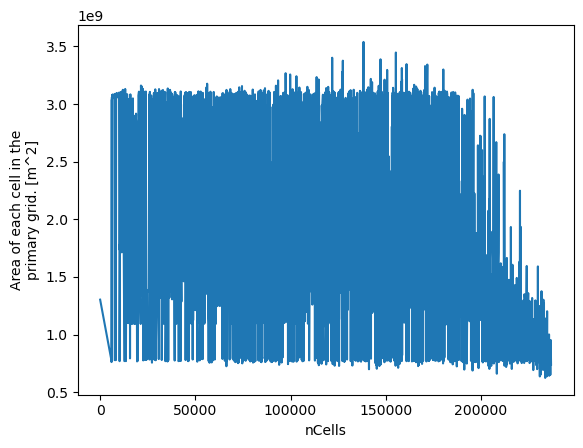

In [63]:
coords.areaCell.plot()

In [64]:
dsMesh = make_planar_hex_mesh(nx=10, ny=20, dc=1000., nonperiodic_x=True,
                              nonperiodic_y=False)
dsMesh = cull(dsMesh)
dsMesh = convert(dsMesh)

cullCell
int32
Running: MpasCellCuller.x /tmp/tmpdak7ssqk/ds_in.nc /tmp/tmpdak7ssqk/ds_out.nc


FileNotFoundError: [Errno 2] No such file or directory: 'MpasCellCuller.x'

Created a base mesh and the converted it to an mpas mesh.

activate environment with the ```mpas_tools``` mesh.\
``` conda activate lanl_env``` 

create a base mesh \
```planar_hex --nx 4 --ny 4 --dc 10e3 -o base_mesh.nc```

"convert to a spec-compliant format" named mesh.nc\
```MpasMeshConverter.x base_mesh.nc mesh.nc```

In [55]:
import xarray as xr
from geometric_features import read_feature_collection
from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf


test_filepath = '/pscratch/sd/k/kuyeda/test_dir/'

dsMesh = xr.open_dataset(test_filepath + 'mesh.nc', decode_cf=False, decode_times=False)
fcMask = read_feature_collection('regions.geojson')
pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell', 'vertex'), pool=pool
)
write_netcdf(dsMasks, 'region_masks.nc')

FileNotFoundError: [Errno 2] No such file or directory: 'regions.geojson'

In [52]:
test_filepath = '/pscratch/sd/k/kuyeda/test_dir/'
gf = GeometricFeatures()
fcLandCoverage = gf.read(
    componentName='natural_earth',
    objectType='region',
    featureNames=['Land Coverage']
)
dsBaseMesh = xr.open_dataset(test_filepath + 'base_mesh.nc')
dsLandMask = mask(dsBaseMesh, fcMask=fcLandCoverage)
dsCulledMesh = cull(dsBaseMesh, dsMask=dsLandMask)
write_netcdf(dsCulledMesh, test_filepath + 'culled_mesh.nc')

Running: compute_mpas_region_masks -m /tmp/tmpzerdext0/mesh_in.nc -o /tmp/tmpzerdext0/mask_out.nc -g /tmp/tmpzerdext0/mask.geojson -t cell --process_count 1 --format NETCDF3_64BIT


FileNotFoundError: [Errno 2] No such file or directory: 'compute_mpas_region_masks'

In [17]:
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
ds = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-09-01.nc')
# list(ds.keys())
# extract tracer and boundary forcing? flux terms
ds_fluxes = ds[['timeMonthly_avg_activeTracers_temperature','timeMonthly_avg_activeTracers_salinity','timeMonthly_avg_shortWaveHeatFlux', 
                'timeMonthly_avg_longWaveHeatFluxUp','timeMonthly_avg_longWaveHeatFluxDown','timeMonthly_avg_latentHeatFlux','timeMonthly_avg_sensibleHeatFlux','timeMonthly_avg_seaIceHeatFlux',
                'timeMonthly_avg_evaporationFlux','timeMonthly_avg_rainFlux','timeMonthly_avg_snowFlux','timeMonthly_avg_riverRunoffFlux','timeMonthly_avg_iceRunoffFlux',
                'timeMonthly_avg_seaIceFreshWaterFlux','timeMonthly_avg_seaIceSalinityFlux','timeMonthly_avg_salinitySurfaceRestoringTendency']]

In [18]:
list(ds.keys())

['binBoundaryMerHeatTrans',
 'binBoundaryMocStreamfunction',
 'timeMonthly_counter',
 'xtime_startMonthly',
 'xtime_endMonthly',
 'timeMonthly_avg_daysSinceStartOfSim',
 'timeMonthly_avg_ssh',
 'timeMonthly_avg_velocityMeridional',
 'timeMonthly_avg_velocityZonal',
 'timeMonthly_avg_layerThickness',
 'timeMonthly_avg_density',
 'timeMonthly_avg_potentialDensity',
 'timeMonthly_avg_windStressZonal',
 'timeMonthly_avg_windStressMeridional',
 'timeMonthly_avg_frazilLayerThicknessTendency',
 'timeMonthly_avg_meridionalHeatTransportLatZ',
 'timeMonthly_avg_meridionalHeatTransportLat',
 'timeMonthly_avg_tThreshMLD',
 'timeMonthly_avg_dThreshMLD',
 'timeMonthly_avg_normalVelocity',
 'timeMonthly_avg_vertVelocityTop',
 'timeMonthly_avg_zMid',
 'timeMonthly_avg_atmosphericPressure',
 'timeMonthly_avg_normalGMBolusVelocity',
 'timeMonthly_avg_vertGMBolusVelocityTop',
 'timeMonthly_avg_GMBolusVelocityZonal',
 'timeMonthly_avg_GMBolusVelocityMeridional',
 'timeMonthly_avg_cGMphaseSpeed',
 'timeMon

In [20]:
ds['timeMonthly_avg_activeTracersSurfaceFlux_temperatureSurfaceFlux']


<xarray.DataArray 'timeMonthly_avg_activeTracersSurfaceFlux_temperatureSurfaceFlux' (
                                                                                     Time: 1,
                                                                                     nCells: 236853)> Size: 947kB
[236853 values with dtype=float32]
Dimensions without coordinates: Time, nCells
Attributes:
    long_name:  Flux of temperature through the ocean surface. Positive into ...
    units:      ^\circ C m s^{-1}